### Multi-layer Perceptron (MLP)

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [7]:
df = pd.read_csv('dataset_final_para_modelo_1_100.csv', decimal=',')

In [8]:
# Seleciona as features finais (numéricas)
y = df['Sinistro']
X = df.drop(columns=['Sinistro', 'data'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

X_train['tipo_via_num'] = X_train['tipo_via_num'].fillna(-1)
X_test['tipo_via_num'] = X_test['tipo_via_num'].fillna(-1)

scaler = StandardScaler() # Resolve problemas de escala entre as features

scaler.fit(X_train)

,copy,True
,with_mean,True
,with_std,True


### RandomizedSearchCV

In [ ]:
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)), 
    ('mlp', MLPClassifier(
        random_state=42,
        early_stopping=True,
        max_iter=500
    ))
])

param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50), (100, 50, 25), (100, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate': ['constant', 'adaptive']
}

grid = RandomizedSearchCV(
    pipeline,                     
    param_distributions=param_grid,
    n_iter=10,                    
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=8
)

grid.fit(X_train, y_train)

print("Busca concluída.")
print("Melhores parâmetros encontrados:")
print(grid.best_params_)
print("\nMelhor score F1 (validação cruzada):")
print(grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


### Treino com hiperparâmetros do GridSearch

In [ ]:
#    hidden_layer_sizes=(100, 50): Define a arquitetura - duas camadas ocultas, a 1ª com 100 neurónios, a 2ª com 50.
#    activation='relu': Função de ativação comum e eficaz.
#    solver='adam': O otimizador padrão e geralmente bom.
#    alpha=0.0001: Termo de regularização L2 para evitar overfitting.
#    max_iter=500: Número máximo de épocas de treino.
#    random_state=8: Para reprodutibilidade.
#    early_stopping=True: Para o treino se a performance não melhorar, evitando overfitting.

mlp_model = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='logistic',
    solver='adam',
    alpha=0.01,
    max_iter=500,
    random_state=8,
    early_stopping=True, # Importante para evitar overfitting
    n_iter_no_change=10, # Número de iterações sem melhora antes de parar
    learning_rate_init=0.01,
    class_weight='balanced' # Importante para lidar com classes desbalanceadas
)

# 2. Treina o modelo com os dados ESCALONADOS
print("Treinando o modelo MLP (pode demorar)...")
mlp_model.fit(X_train_scaled, y_train)
print("Treinamento concluído.")

Inicializando o modelo MLP...
Treinando o modelo MLP (pode demorar)...
Treinamento concluído.



--- Avaliação do Modelo MLP ---

--- Matriz de Confusão (MLP) ---

--- Relatório de Classificação (MLP) ---
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      4914
           1       0.93      0.59      0.72      2457

    accuracy                           0.85      7371
   macro avg       0.88      0.78      0.81      7371
weighted avg       0.86      0.85      0.84      7371

--- AUC (MLP) ---
0.8549


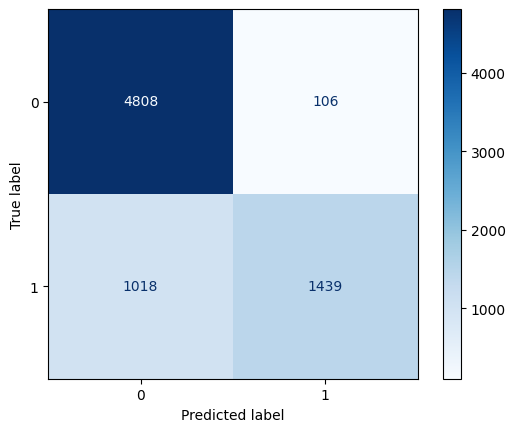

In [11]:
# 3. Faz as previsões e avalia, usando os dados de teste ESCALONADOS
print("\n--- Avaliação do Modelo MLP ---")
y_pred_mlp = mlp_model.predict(X_test_scaled)

print("\n--- Matriz de Confusão (MLP) ---")
cm = confusion_matrix(y_test, y_pred_mlp)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

print("\n--- Relatório de Classificação (MLP) ---")
print(classification_report(y_test, y_pred_mlp))

# Calcula a AUC (requer probabilidades)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
auc_mlp = roc_auc_score(y_test, y_prob_mlp)
print(f"--- AUC (MLP) ---")
print(f"{auc_mlp:.4f}")